# animal_classification **using** Convolutional Neural Network

###importing necessary libraries

In [3]:
import pandas as pd
import numpy as np
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import datetime
import time

ModuleNotFoundError: No module named 'tensorflow'

###Looking up our image **dataset**

In [6]:
#Default dimensions
img_width, img_height = 224, 224

#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model.h5'

# loading up our datasets
train_data_dir = '/content/drive/MyDrive/Projects-20240722T093004Z-001/Projects/animal_classification/Animal Classification/dataset'
validation_data_dir = '/content/drive/MyDrive/Projects-20240722T093004Z-001/Projects/animal_classification/Animal Classification/dataset'
test_data_dir = '/content/drive/MyDrive/Projects-20240722T093004Z-001/Projects/animal_classification/Animal Classification/dataset'

# number of epochs to train top model
epochs = 10

# batch size used by flow_from_directory and predict_generator
batch_size = 50

###Loading vgc16 model

In [3]:
vgg16 = applications.VGG16(include_top=False, weights='imagenet')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
datagen = ImageDataGenerator(rescale=1. / 255)  #needed to create the bottleneck .npy files

### Creation of weights/features with VGG16

In [5]:
#run this only once
start = datetime.datetime.now()

generator = datagen.flow_from_directory(
train_data_dir,
target_size=(img_width, img_height),
batch_size=batch_size,
class_mode=None,
shuffle=False)

nb_train_samples = len(generator.filenames)
num_classes = len(generator.class_indices)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))

# Use predict instead of predict_generator
bottleneck_features_train = vgg16.predict(generator, steps=predict_size_train) # Changed to predict, added steps argument

np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 1944 images belonging to 15 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 1294s 33s/step
Time:  0:22:28.453333


In [7]:
#run this only once
start = datetime.datetime.now()
generator = datagen.flow_from_directory(
     validation_data_dir,
     target_size=(img_width, img_height),
     batch_size=batch_size,
     class_mode=None,
     shuffle=False)

nb_validation_samples = len(generator.filenames)

predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

# Use predict instead of predict_generator and add the steps argument
bottleneck_features_validation = vgg16.predict(generator, steps=predict_size_validation)

np.save('bottleneck_features_validation.npy', bottleneck_features_validation)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 1944 images belonging to 15 classes.
39/39 ━━━━━━━━━━━━━━━━━━━━ 1317s 34s/step
Time:  0:21:59.043864


In [8]:
#run this only once
start = datetime.datetime.now()
generator = datagen.flow_from_directory(
     test_data_dir,
     target_size=(img_width, img_height),
     batch_size=batch_size,
     class_mode=None,
     shuffle=False)
nb_test_samples = len(generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))
# Replace predict_generator with predict and add the steps argument
bottleneck_features_test = vgg16.predict(generator, steps=predict_size_test)
np.save('bottleneck_features_test.npy', bottleneck_features_test)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 1944 images belonging to 15 classes.
39/39 ━━━━━━━━━━━━━━━━━━━━ 1261s 32s/step
Time:  0:21:03.009434


###Loading training, validation and testing data

In [9]:
#training data
generator_top = datagen.flow_from_directory(
         train_data_dir,
         target_size=(img_width, img_height),
         batch_size=batch_size,
         class_mode='categorical',
         shuffle=False)
nb_train_samples = len(generator_top.filenames)
num_classes = len(generator_top.class_indices)

# load the bottleneck features saved earlier
train_data = np.load('bottleneck_features_train.npy')

# get the class lebels for the training data, in the original order
train_labels = generator_top.classes

# convert the training labels to categorical vectors
train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 1944 images belonging to 15 classes.


In [10]:
#validation data
generator_top = datagen.flow_from_directory(
         validation_data_dir,
         target_size=(img_width, img_height),
         batch_size=batch_size,
         class_mode=None,
         shuffle=False)

nb_validation_samples = len(generator_top.filenames)

validation_data = np.load('bottleneck_features_validation.npy')

validation_labels = generator_top.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

Found 1944 images belonging to 15 classes.


In [11]:
#testing data
generator_top = datagen.flow_from_directory(
         test_data_dir,
         target_size=(img_width, img_height),
         batch_size=batch_size,
         class_mode=None,
         shuffle=False)

nb_test_samples = len(generator_top.filenames)

test_data = np.load('bottleneck_features_test.npy')

test_labels = generator_top.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 1944 images belonging to 15 classes.


##Training of model

In [12]:
start = datetime.datetime.now()
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.5))
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4), # Changed lr to learning_rate
              metrics=['acc'])

history = model.fit(train_data, train_labels,
      epochs=10,
      batch_size=batch_size,
      validation_data=(validation_data, validation_labels))

model.save_weights('bottleneck_fc_model.weights.h5')

(eval_loss, eval_accuracy) = model.evaluate(
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - acc: 0.1062 - loss: 2.8094 - val_acc: 0.4599 - val_loss: 2.1489
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - acc: 0.2997 - loss: 2.2159 - val_acc: 0.5720 - val_loss: 1.7391
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - acc: 0.4197 - loss: 1.8899 - val_acc: 0.6662 - val_loss: 1.4824
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - acc: 0.4909 - loss: 1.6590 - val_acc: 0.7536 - val_loss: 1.2146
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - acc: 0.5610 - loss: 1.4801 - val_acc: 0.7917 - val_loss: 1.0791
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - acc: 0.6038 - loss: 1.3177 - val_acc: 0.7793 - val_loss: 0.9967
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - acc: 0.6323 - loss: 1.2537 - val_acc: 0.7999 - val_loss: 0.8680
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - acc: 0.6626 - loss: 1.1513 - val_acc: 0.8256 - val_loss: 0.8126
Epoch 9/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - acc: 0.6821

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       2,508,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 15)                  │             765 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,029,432 (19.19 MB)

 Trainable params: 2,514,715 (9.59 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,514,717 (9.59 MB)

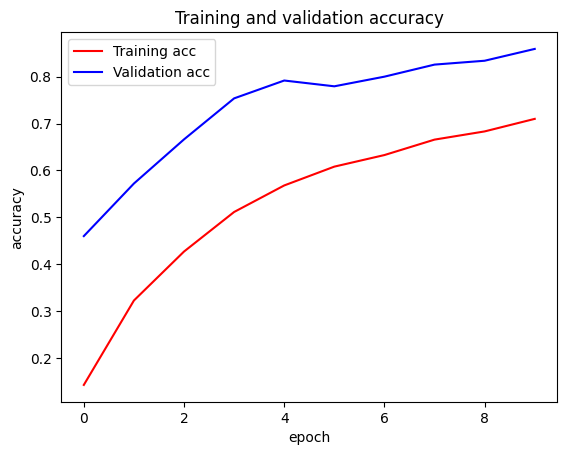

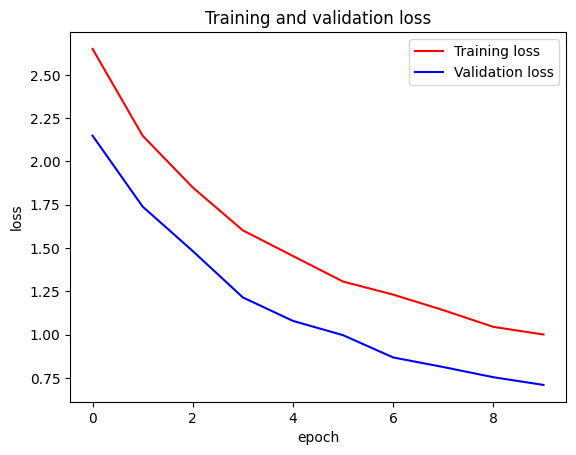

In [15]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

###Model Evaluation on Testing Set

In [16]:
model.evaluate(test_data, test_labels)

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.8419 - loss: 0.7273


[0.7093391418457031, 0.8590534925460815]

###Classification metrics

In [17]:
print('test data', test_data)
preds = np.round(model.predict(test_data),0)
#to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded test_labels', preds)

test data [[[[2.52881110e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    9.44856882e-01 0.00000000e+00]
   [5.80378324e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    6.14194751e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 1.72222972e+00 ... 0.00000000e+00
    3.06941956e-01 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 5.27550459e-01 ... 0.00000000e+00
    6.82952881e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    7.26413012e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    7.17371285e-01 0.00000000e+00]]

  [[3.58356327e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    1.00833511e+00 0.00000000e+00]
   [1.36282042e-01 0.00000000e+00 5.38208246e-01 ... 0.00000000e+00
    6.63874507e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 2.95038986e+00 ... 0.00000000e+00
    2.32425928e-02 0.00000000e+00]
   ...
   [1.06330097e+00 0.00000000e+00 2.35156655e+0

In [18]:
animals = ['Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin', 'Elephant', 'Giraffe', 'Horse', 'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Zebra']
classification_metrics = metrics.classification_report(test_labels, preds, target_names=animals )
print(classification_metrics)

              precision    recall  f1-score   support

        Bear       1.00      0.72      0.84       125
        Bird       1.00      0.75      0.86       137
         Cat       1.00      0.68      0.81       123
         Cow       1.00      0.65      0.79       131
        Deer       1.00      0.61      0.75       127
         Dog       1.00      0.69      0.82       122
     Dolphin       1.00      0.75      0.86       129
    Elephant       1.00      0.71      0.83       133
     Giraffe       1.00      0.77      0.87       129
       Horse       1.00      0.68      0.81       130
    Kangaroo       1.00      0.72      0.84       126
        Lion       1.00      0.60      0.75       131
       Panda       1.00      0.77      0.87       135
       Tiger       1.00      0.76      0.86       129
       Zebra       1.00      0.79      0.88       137

   micro avg       1.00      0.71      0.83      1944
   macro avg       1.00      0.71      0.83      1944
weighted avg       1.00   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


###Confusion Matrix

In [19]:
#Since our data is in dummy format we put the numpy array into a dataframe and call idxmax axis=1 to return the column
#label of the maximum value thos creating a categorical variable
#Basically, flipping a dummy variable back to it's categorical variable
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

In [20]:
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

In [21]:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
#Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


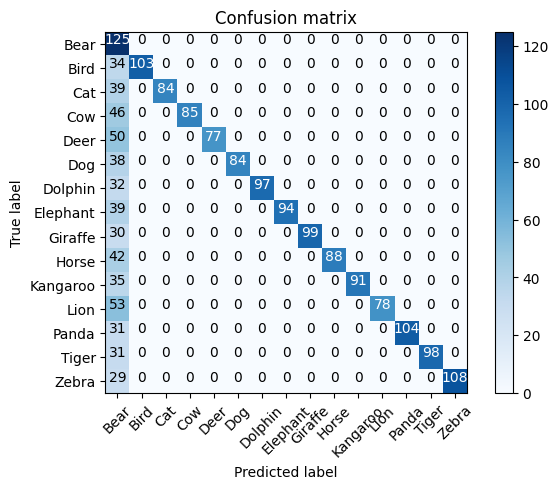

In [22]:
plot_confusion_matrix(confusion_matrix, ['Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin', 'Elephant', 'Giraffe', 'Horse', 'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Zebra'])

Normalized confusion matrix


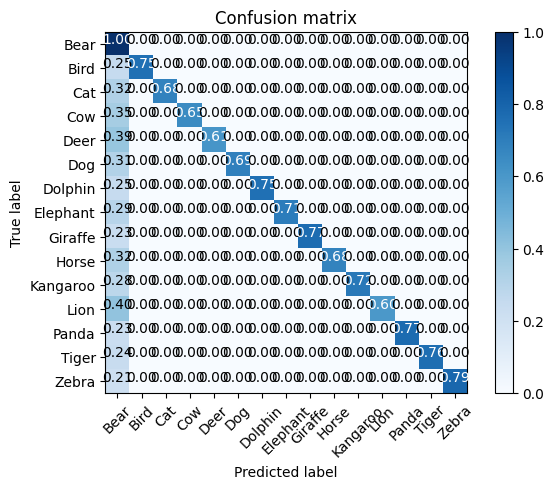

In [23]:
#Those numbers are all over the place. Now turning normalize= True
plot_confusion_matrix(confusion_matrix,
                      ['Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin', 'Elephant', 'Giraffe', 'Horse', 'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Zebra'],
                     normalize=True)

###Testing images on model

In [24]:
def read_image(file_path):
    print("[INFO] loading and preprocessing image...")
    image = load_img(file_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image /= 255.
    return image

In [25]:
def test_single_image(path):
    animals = ['Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin', 'Elephant', 'Giraffe', 'Horse', 'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Zebra']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images)
    # Use predict instead of predict_proba and extract probabilities
    preds = model.predict(bt_prediction)
    # Assuming your model has a softmax output layer, preds will contain probabilities
    for idx, animal, x in zip(range(0,6), animals , preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100,2) ))
    print('Final Decision:')
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
        time.sleep(.2)
    # Use predict and argmax to get predicted class
    class_predicted = np.argmax(model.predict(bt_prediction), axis=-1)
    class_dictionary = generator_top.class_indices
    inv_map = {v: k for k, v in class_dictionary.items()}
    print("ID: {}, Label: {}".format(class_predicted[0], inv_map[class_predicted[0]]))
    return load_img(path)

In [26]:
#path of image that is used for testing
Beer = '/content/drive/MyDrive/Projects-20240722T093004Z-001/Projects/animal_classification/Animal Classification/dataset/Bear/Bear_10.jpg'

[INFO] loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
ID: 0, Label: Bear 96.76%
ID: 1, Label: Bird 0.01%
ID: 2, Label: Cat 0.07%
ID: 3, Label: Cow 0.11%
ID: 4, Label: Deer 0.0%
ID: 5, Label: Dog 1.11%
Final Decision:
.
..
...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
ID: 0, Label: Bear


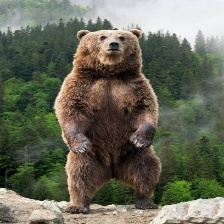

In [27]:
test_single_image(Beer)

In [28]:
#path of image that is used for testing
Bird = '/content/drive/MyDrive/Projects-20240722T093004Z-001/Projects/animal_classification/Animal Classification/dataset/Bird/Bird_10_3.jpg'

[INFO] loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
ID: 0, Label: Bear 0.08%
ID: 1, Label: Bird 95.62%
ID: 2, Label: Cat 0.41%
ID: 3, Label: Cow 0.57%
ID: 4, Label: Deer 0.02%
ID: 5, Label: Dog 0.64%
Final Decision:
.
..
...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
ID: 1, Label: Bird


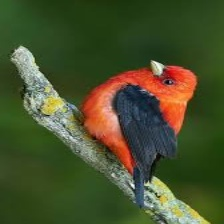

In [29]:
test_single_image(Bird)

In [30]:
#path of image that is used for testing
Cat = '/content/drive/MyDrive/Projects-20240722T093004Z-001/Projects/animal_classification/Animal Classification/dataset/Cat/Cat_14_2.jpg'

[INFO] loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
ID: 0, Label: Bear 5.73%
ID: 1, Label: Bird 8.56%
ID: 2, Label: Cat 9.74%
ID: 3, Label: Cow 5.03%
ID: 4, Label: Deer 5.36%
ID: 5, Label: Dog 9.27%
Final Decision:
.
..
...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
ID: 2, Label: Cat


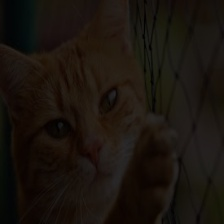

In [31]:
test_single_image(Cat)

In [32]:
#path of image that is used for testing
Cow = '/content/drive/MyDrive/Projects-20240722T093004Z-001/Projects/animal_classification/Animal Classification/dataset/Cow/Cow_19_1.jpg'

[INFO] loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
ID: 0, Label: Bear 0.21%
ID: 1, Label: Bird 0.05%
ID: 2, Label: Cat 0.04%
ID: 3, Label: Cow 93.63%
ID: 4, Label: Deer 1.03%
ID: 5, Label: Dog 0.71%
Final Decision:
.
..
...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
ID: 3, Label: Cow


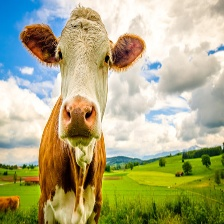

In [33]:
test_single_image(Cow)

In [34]:
#path of image that is used for testing
Deer = '/content/drive/MyDrive/Projects-20240722T093004Z-001/Projects/animal_classification/Animal Classification/dataset/Deer/Deer_13.jpg'

[INFO] loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
ID: 0, Label: Bear 0.08%
ID: 1, Label: Bird 0.12%
ID: 2, Label: Cat 0.22%
ID: 3, Label: Cow 1.89%
ID: 4, Label: Deer 91.6%
ID: 5, Label: Dog 0.05%
Final Decision:
.
..
...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
ID: 4, Label: Deer


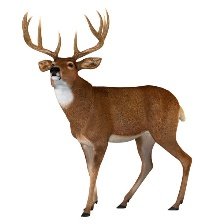

In [35]:
test_single_image(Deer)

In [36]:
#path of image that is used for testing
Dog = '/content/drive/MyDrive/Projects-20240722T093004Z-001/Projects/animal_classification/Animal Classification/dataset/Dog/Dog_13_3.jpg'

[INFO] loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
ID: 0, Label: Bear 7.08%
ID: 1, Label: Bird 5.32%
ID: 2, Label: Cat 6.34%
ID: 3, Label: Cow 5.24%
ID: 4, Label: Deer 5.0%
ID: 5, Label: Dog 11.65%
Final Decision:
.
..
...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
ID: 5, Label: Dog


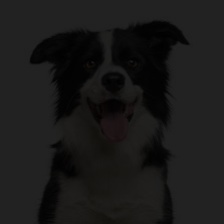

In [37]:
test_single_image(Dog)

In [38]:
#path of image that is used for testing
Dolphin = '/content/drive/MyDrive/Projects-20240722T093004Z-001/Projects/animal_classification/Animal Classification/dataset/Dolphin/Dolphin_10.jpg'

[INFO] loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
ID: 0, Label: Bear 0.77%
ID: 1, Label: Bird 0.06%
ID: 2, Label: Cat 0.01%
ID: 3, Label: Cow 0.06%
ID: 4, Label: Deer 0.02%
ID: 5, Label: Dog 0.02%
Final Decision:
.
..
...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
ID: 6, Label: Dolphin


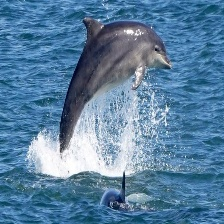

In [39]:
test_single_image(Dolphin)

In [40]:
#path of image that is used for testing
Elephant = '/content/drive/MyDrive/Projects-20240722T093004Z-001/Projects/animal_classification/Animal Classification/dataset/Elephant/Elephant_12_1.jpg'

[INFO] loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
ID: 0, Label: Bear 0.78%
ID: 1, Label: Bird 0.06%
ID: 2, Label: Cat 0.46%
ID: 3, Label: Cow 2.53%
ID: 4, Label: Deer 0.29%
ID: 5, Label: Dog 0.56%
Final Decision:
.
..
...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
ID: 7, Label: Elephant


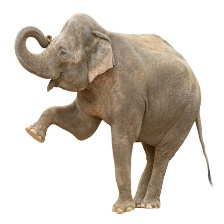

In [41]:
test_single_image(Elephant)

In [42]:
#path of image that is used for testing
Giraffe = '/content/drive/MyDrive/Projects-20240722T093004Z-001/Projects/animal_classification/Animal Classification/dataset/Giraffe/Giraffe_14_3.jpg'

[INFO] loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
ID: 0, Label: Bear 4.3%
ID: 1, Label: Bird 8.21%
ID: 2, Label: Cat 6.5%
ID: 3, Label: Cow 2.98%
ID: 4, Label: Deer 4.29%
ID: 5, Label: Dog 7.89%
Final Decision:
.
..
...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
ID: 8, Label: Giraffe


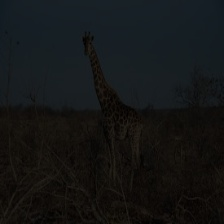

In [43]:
test_single_image(Giraffe)

In [44]:
#path of image that is used for testing
Horse = '/content/drive/MyDrive/Projects-20240722T093004Z-001/Projects/animal_classification/Animal Classification/dataset/Horse/Horse_24_3.jpg'

[INFO] loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
ID: 0, Label: Bear 0.84%
ID: 1, Label: Bird 4.66%
ID: 2, Label: Cat 2.08%
ID: 3, Label: Cow 0.14%
ID: 4, Label: Deer 2.04%
ID: 5, Label: Dog 1.74%
Final Decision:
.
..
...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
ID: 9, Label: Horse


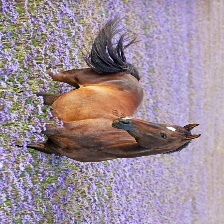

In [45]:
test_single_image(Horse)

In [46]:
#path of image that is used for testing
Kangaroo = '/content/drive/MyDrive/Projects-20240722T093004Z-001/Projects/animal_classification/Animal Classification/dataset/Kangaroo/Kangaroo_23.jpeg'

[INFO] loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
ID: 0, Label: Bear 0.56%
ID: 1, Label: Bird 0.1%
ID: 2, Label: Cat 0.23%
ID: 3, Label: Cow 1.13%
ID: 4, Label: Deer 0.65%
ID: 5, Label: Dog 0.47%
Final Decision:
.
..
...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
ID: 10, Label: Kangaroo


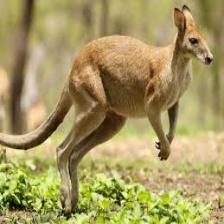

In [47]:
test_single_image(Kangaroo)

In [48]:
#path of image that is used for testing
Lion = '/content/drive/MyDrive/Projects-20240722T093004Z-001/Projects/animal_classification/Animal Classification/dataset/Lion/Lion_2_4.jpg'

[INFO] loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
ID: 0, Label: Bear 7.94%
ID: 1, Label: Bird 2.73%
ID: 2, Label: Cat 3.87%
ID: 3, Label: Cow 0.63%
ID: 4, Label: Deer 0.91%
ID: 5, Label: Dog 7.21%
Final Decision:
.
..
...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
ID: 7, Label: Elephant


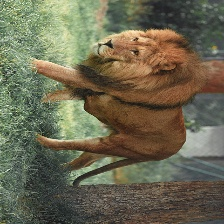

In [49]:
test_single_image(Lion)

In [50]:
#path of image that is used for testing
Panda = '/content/drive/MyDrive/Projects-20240722T093004Z-001/Projects/animal_classification/Animal Classification/dataset/Panda/Panda_27.jpeg'

[INFO] loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
ID: 0, Label: Bear 0.65%
ID: 1, Label: Bird 0.12%
ID: 2, Label: Cat 0.1%
ID: 3, Label: Cow 0.37%
ID: 4, Label: Deer 0.04%
ID: 5, Label: Dog 1.16%
Final Decision:
.
..
...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
ID: 12, Label: Panda


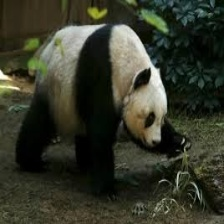

In [51]:
test_single_image(Panda)

In [52]:
  #path of image that is used for testing
Tiger = '/content/drive/MyDrive/Projects-20240722T093004Z-001/Projects/animal_classification/Animal Classification/dataset/Tiger/Tiger_22_3.jpg'

[INFO] loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
ID: 0, Label: Bear 7.07%
ID: 1, Label: Bird 5.34%
ID: 2, Label: Cat 5.6%
ID: 3, Label: Cow 6.01%
ID: 4, Label: Deer 4.83%
ID: 5, Label: Dog 8.27%
Final Decision:
.
..
...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
ID: 12, Label: Panda


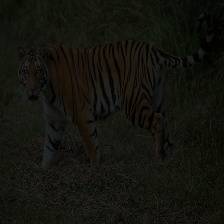

In [53]:
test_single_image(Tiger)

In [54]:
#path of image that is used for testing
Zebra = '/content/drive/MyDrive/Projects-20240722T093004Z-001/Projects/animal_classification/Animal Classification/dataset/Zebra/Zebra_9_4.jpg'

[INFO] loading and preprocessing image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
ID: 0, Label: Bear 0.01%
ID: 1, Label: Bird 0.07%
ID: 2, Label: Cat 0.12%
ID: 3, Label: Cow 0.28%
ID: 4, Label: Deer 0.07%
ID: 5, Label: Dog 0.01%
Final Decision:
.
..
...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
ID: 14, Label: Zebra


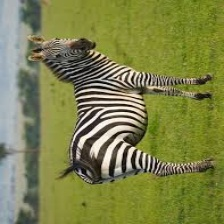

In [55]:
test_single_image(Zebra)